## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Splitting into train and test
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=1234)

print(len(train_set))
print(len(test_set))

3718
196


In [4]:
# The below piece of code prepares dictionaries from training set which would be used to calculate
# emission & transition probabilities - used by Viterbi algorithms.

# generator - returns tuple i.e. (word,tag) pair for all the sentences.
train_word_tag = (word for sentence in train_set for word in sentence)

# dictionary to keep count for each word_tag combination.
word_tag_count_dict = {}

# dictionary to keep count for each tag.
tag_count_dict = {}

# dictionary to keep count for each tag1_followed_tag2 combination.
tag1_followed_tag2 = {}
skip = True

# looping for train_word_tag pair
for word_tag in train_word_tag:
    
    # key is word_tag combination.
    key = word_tag[0]+'_'+ word_tag[1]
    
    # getting the count from word_tag_count dictionary if it is not found then set to 1 otherwise increment by 1
    count_word_tag = word_tag_count_dict.get(key)        
    if count_word_tag is None :
        word_tag_count_dict[key] = 1
    else :
        word_tag_count_dict[key] = count_word_tag + 1
        
    # getting the count from tag_count dict if it is not found then set to 1 otherwise increment by 1
    count_tag = tag_count_dict.get(word_tag[1])
    if count_tag is None :
        tag_count_dict[word_tag[1]] = 1
    else :
        tag_count_dict[word_tag[1]] = count_tag + 1
    
    if skip == False:
        current_tag = word_tag[1]
        # generating key for tag1_followed_tag2 with prevTag from previous iteration 
        # & current_tag from current iteration.
        key = prev_tag+'_'+current_tag
        # getting the count from tag1_followed_tag2 dictionary if it is not found then set to 1 
        # otherwise increment by 1
        count_tag1_followed_tag2 = tag1_followed_tag2.get(key)
        if count_tag1_followed_tag2 is None :
            tag1_followed_tag2[key] = 1
        else :
            tag1_followed_tag2[key] = count_tag1_followed_tag2 + 1
        prev_tag = current_tag        
    # for the very 1st iteration prev_tag is set to current tag    
    else :
        prev_tag = word_tag[1]
        skip = False


In [5]:
# creating t * t matrix for transition probabilities

# getting tag list from tag_count dictionary
tag_list = list(tag_count_dict.keys())

# getting count of unique tags
num_tags = len(tag_list)

# Preparing transition matrix for [unique tags * unique tags] shape
transition_matrix = np.zeros(num_tags * num_tags, dtype=np.float64).reshape(num_tags,-1)

# looping over tag list
for i, tag1 in enumerate(tag_list):
    # looping over tag list
    for j, tag2 in enumerate(tag_list):
        #prepairing key for tag1_followed_tag2 dictionary
        key = tag1+'_'+tag2
        
        # getting the count & if it is not found then setting it to 0
        count_tag1_followed_tag2 = tag1_followed_tag2.get(key)
        if count_tag1_followed_tag2 is None :
            count_tag1_followed_tag2 = 0
        #setting value in transition matrix
        transition_matrix[i,j] = count_tag1_followed_tag2 / tag_count_dict.get(tag1)

In [6]:
# Creating Bigram tagger which is backoff by Unigram tagger which is backed off with Regular Expression tagger 
# backed off with Default tagger. 

patterns = [
    (r'.*ing$', 'VERB'),              
    (r'.*ed$', 'VERB'),               
    (r'.*es$', 'VERB'),               
    (r'.*\'s$', 'NOUN'),              
    (r'.*s$', 'NOUN'),                
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), 
    (r'.*', 'NOUN')                    
]
regexp_tagger = nltk.RegexpTagger(patterns,backoff = nltk.DefaultTagger('NOUN'))
unigram_tagger = nltk.UnigramTagger(train_set,backoff=regexp_tagger)
bigram_tagger = nltk.BigramTagger(train_set,backoff=unigram_tagger)

In [7]:
# for better viewing creating data frame & displaying it.

tags_df = pd.DataFrame(transition_matrix, columns = tag_list , index=tag_list)
tags_df

,DET,NOUN,.,ADP,ADJ,VERB,X,NUM,CONJ,ADV,PRT,PRON
DET,0.005442,0.638650,0.017777,0.009191,0.203652,0.039545,0.046197,0.022373,0.000484,0.012698,0.000242,0.003749
NOUN,0.013250,0.264898,0.239307,0.177023,0.012231,0.146336,0.029231,0.009537,0.042263,0.017182,0.043974,0.004769
.,0.173226,0.223091,0.094070,0.090386,0.044654,0.088769,0.027314,0.080593,0.057772,0.051932,0.002336,0.065768
ADP,0.322893,0.322893,0.039842,0.016512,0.105785,0.008522,0.035048,0.062001,0.000959,0.013849,0.001491,0.070203
ADJ,0.004948,0.698499,0.065809,0.077519,0.065314,0.012205,0.021442,0.021112,0.016658,0.004948,0.010886,0.000660
VERB,0.133617,0.110844,0.035167,0.091402,0.065221,0.167622,0.217816,0.022696,0.005577,0.083501,0.031216,0.035321
X,0.054114,0.062184,0.162816,0.144937,0.016456,0.204114,0.074842,0.002690,0.010759,0.026108,0.184652,0.056329
NUM,0.002973,0.354637,0.115933,0.035672,0.032402,0.018133,0.210464,0.184899,0.013377,0.002973,0.027051,0.001486
CONJ,0.118470,0.348881,0.033116,0.052705,0.118937,0.158582,0.008862,0.041511,0.000466,0.055970,0.005131,0.057369
ADV,0.068480,0.031127,0.134666,0.118611,0.129751,0.344364,0.023263,0.031455,0.006881,0.081258,0.014744,0.015400


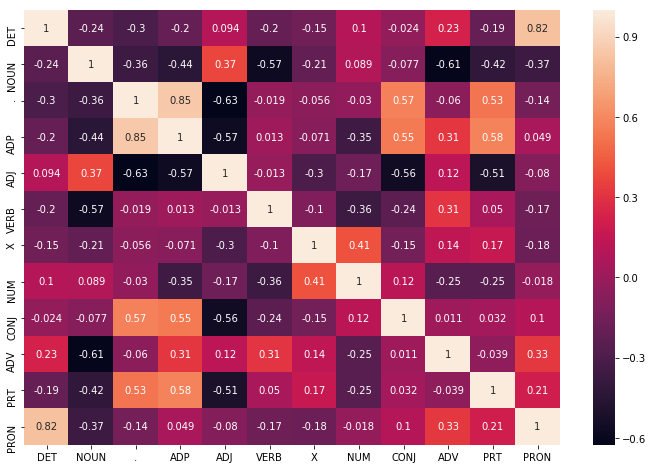

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(tags_df.corr(),annot=True)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [9]:
# VANILLA VITERBI IMPLEMENTATION

def VanillaViterbi(words, tags_bag = tag_list):
    state = []
    
    # looping over all the words to determine pos tags.
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []   
        
        # looping over tag in tags_bag
        for tag in tags_bag:
            
            # for the very 1st iteration prepare key for transition probability & get the value
            if key == 0:
                transition_key ='.'+'_'+tag                
                transition_prob = tag1_followed_tag2.get(transition_key) / tag_count_dict.get('.')               
            
            # for the subsequent iterations prepare key for transition probability & get the value
            else:
                transition_key = prevTag+'_'+tag                
                transition_prob = tag1_followed_tag2.get(transition_key) / tag_count_dict.get(prevTag)              
                
            # compute emission probabilities
            
            # preparing key for word_tag_count dictionary to get numerator
            emission_key = word + '_' + tag
            emission_prob_numerator = word_tag_count_dict.get(emission_key)
            
            # getting denominator from tag_count dictionary
            emission_prob_denominator = tag_count_dict.get(tag)  
            
            if emission_prob_numerator is None:
                emission_prob_numerator = 0            
            
            emission_prob = emission_prob_numerator / emission_prob_denominator
            
            # calculating state probability
            state_probability = emission_prob * transition_prob    
            # append state probability to the probability list
            p.append(state_probability)
            
        
        # getting maximum probability
        p_max = max(p)
        
        # getting state for which probability is maximum
        state_max = tags_bag[p.index(p_max)] 
        
        state.append(state_max)
        prevTag = state_max
    return list(zip(words, state))

### Solve the problem of unknown words

In [10]:
# VITERBI UPDATE 1 - using transition or emission probability to tag unknown words

def ViterbiUpdate_1(words, tags_bag = tag_list):
    state = []
    emission_prob = 0
    transition_prob = 0
        
    # looping over all the words to determine pos tags.
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        e_p = []
        
        # looping over tag in tags_bag
        for tag in tags_bag:
            # for the very 1st iteration prepare key for transition probability & get the value
            if key == 0:
                transition_key ='.'+'_'+tag   
                prevTag = '.'
                transition_prob_numerator = tag1_followed_tag2.get(transition_key)
                if transition_prob_numerator is None:
                       transition_prob_numerator = 0
                
                transition_prob =  transition_prob_numerator / tag_count_dict.get('.')            
                
            # for the subsequent iterations prepare key for transition probability & get the value
            else:
                transition_key = prevTag+'_'+tag
                transition_prob_numerator = tag1_followed_tag2.get(transition_key)
                if transition_prob_numerator is None:
                       transition_prob_numerator = 0

                transition_prob = transition_prob_numerator / tag_count_dict.get(prevTag)                     
            
            # compute emission probabilities
            
            # preparing key for word_tag_count dictionary to get numerator
            emission_key = word + '_' + tag
            emission_prob_numerator = word_tag_count_dict.get(emission_key)
            
            # getting denominator from tag_count dictionary
            emission_prob_denominator = tag_count_dict.get(tag)  
            
            if emission_prob_numerator is None:
                emission_prob_numerator = 0                        
                        
            emission_prob = emission_prob_numerator / emission_prob_denominator
            
            # calculating state probability
            state_probability = emission_prob * transition_prob  
            # append emission probability to emission probability list
            e_p.append(emission_prob)
            # append state probability to the probability list
            p.append(state_probability)
            
        # getting maximum probability       
        p_max = max(p)
        
        # Modified Viterbi - using only transition probability when emission probability is 0 
        # & emission probability when transition probability is 0 for unknown words
        if p_max == 0 :
            if transition_prob == 0 :
                # getting max value of emission probability
                e_p_max = max(e_p)
                # getting pos tag for the max value
                state_max = tags_bag[e_p.index(e_P_max)]
            else :
                # getting the max value of transition probability with prev tag
                state_max = tag_list[np.unravel_index(transition_matrix[tag_list.index(prevTag)].argmax(), 
                            transition_matrix[tag_list.index(prevTag)].shape)[0]]
        else :
            state_max = tags_bag[p.index(p_max)] 
        
        state.append(state_max)
        prevTag = state_max
    return list(zip(words, state))

In [11]:
# Viterbi Update 2 - using Lexicon Tagger to predict tag for unknown words.

def ViterbiUpdate_2(words, bigram_tagger,tags_bag = tag_list):
    state = []
    emission_prob = 0
    transition_prob = 0
        
    # looping over all the words to determine pos tags.
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        e_p = []
        
        # looping over tag in tags_bag
        for tag in tags_bag:
            # for the very 1st iteration prepare key for transition probability & get the value
            if key == 0:
                transition_key ='.'+'_'+tag   
                prevTag = '.'
                transition_prob_numerator = tag1_followed_tag2.get(transition_key)
                if transition_prob_numerator is None:
                       transition_prob_numerator = 0
                
                transition_prob =  transition_prob_numerator / tag_count_dict.get('.')            
                
            # for the subsequent iterations prepare key for transition probability & get the value
            else:
                transition_key = prevTag+'_'+tag
                transition_prob_numerator = tag1_followed_tag2.get(transition_key)
                if transition_prob_numerator is None:
                       transition_prob_numerator = 0

                transition_prob = transition_prob_numerator / tag_count_dict.get(prevTag)                     
            
            # compute emission probabilities
            
            # preparing key for word_tag_count dictionary to get numerator
            emission_key = word + '_' + tag
            emission_prob_numerator = word_tag_count_dict.get(emission_key)
            
            # getting denominator from tag_count dictionary
            emission_prob_denominator = tag_count_dict.get(tag)  
            
            if emission_prob_numerator is None:
                emission_prob_numerator = 0                        
                        
            emission_prob = emission_prob_numerator / emission_prob_denominator
            
            # calculating state probability
            state_probability = emission_prob * transition_prob  
            # append emission probability to emission probability list
            e_p.append(emission_prob)
            # append state probability to the probability list
            p.append(state_probability)
            
        # getting maximum probability       
        p_max = max(p)
        
        # Modified Viterbi - using Lexicon tagger to get tag for unknown word.
        if p_max == 0 :
            state_max = bigram_tagger.tag([word])[0][1]
        else :
            state_max = tags_bag[p.index(p_max)] 
        
        state.append(state_max)
        prevTag = state_max
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [12]:
# preparing word & word_tag pair list for validation set
validation_word_tag = [word for sentence in test_set for word in sentence]
validation_word = [word[0] for sentence in test_set for word in sentence]

In [13]:
# function to check the accuracy of tagged_seq w.r.t validation wordtag
def accuracy_check(tagged_sequence, tagged_word_tag):
    check = [i for i, j in zip(tagged_sequence, tagged_word_tag) if i == j] 
    accuracy = len(check)/len(tagged_sequence)
    return format(round(accuracy*100,2))

In [14]:
# Vanilla Viterbi
start = time.time()
vanilla_viterbi_seq = VanillaViterbi(validation_word, tag_list)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
vanilla_viterbi_accuracy = accuracy_check(vanilla_viterbi_seq, validation_word_tag)
print('Vanilla Viterbi Accuracy {0}'.format(vanilla_viterbi_accuracy))

Time taken in seconds:  0.15511298179626465
Vanilla Viterbi Accuracy 90.67


In [15]:
# Viterbi Update 1 - using Transition & Emission Probability to find out tag when either one of them is zero.
start = time.time()
viterbi_update1_seq = ViterbiUpdate_1(validation_word, tag_list)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
viterbi_update1_accuracy = accuracy_check(viterbi_update1_seq, validation_word_tag)
print('Viterbi Modification 1 Accuracy {0}'.format(viterbi_update1_accuracy))

Time taken in seconds:  0.10384702682495117
Viterbi Modification 1 Accuracy 93.6


In [16]:
# Viterbi Update 2 - using Bigram Tagger for Unknown words
start = time.time()
viterbi_update2_seq = ViterbiUpdate_2(validation_word, bigram_tagger,tag_list)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
viterbi_update2_accuracy = accuracy_check(viterbi_update2_seq, validation_word_tag)
print('Viterbi Modification 2 Accuracy {0}'.format(viterbi_update2_accuracy))

Time taken in seconds:  0.09915328025817871
Viterbi Modification 2 Accuracy 95.02


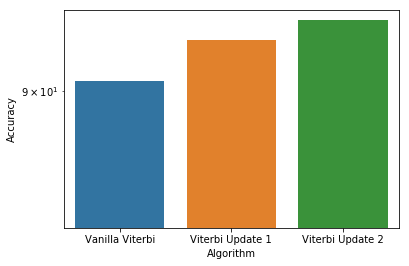

In [17]:
accuracy_array = [float(vanilla_viterbi_accuracy),
                  float(viterbi_update1_accuracy),
                  float(viterbi_update2_accuracy)]
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.yscale('log')
sns.barplot(x=['Vanilla Viterbi','Viterbi Update 1', 'Viterbi Update 2'], y=accuracy_array)
plt.show()

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [18]:
# loading the test sentences file
test_sentences = []
with open('Test_sentences.txt','r') as f:
    test_sentences = f.readlines()

# striping new line character from all the sentences.
test_sentences = [s.rstrip('\n') for s in test_sentences]

test_word_file = []
# word tokenizing using nltk.pos_tag library with tagset set to universal.
for sentence in test_sentences:
    tokenized_text = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokenized_text,tagset='universal')
    test_word_file.append(tagged)

# creating test sentences word_tag & word lists    
test_sentences_words_tag = [word for sentence in test_word_file for word in sentence]
test_sentences_words = [word[0] for sentence in test_word_file for word in sentence]

In [19]:
# Running Vanilla Viterbi on Test Sentences
start = time.time()
tagged_seq_vanilla = VanillaViterbi(test_sentences_words, tag_list)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
vanilla_viterbi_accuracy = accuracy_check(tagged_seq_vanilla, test_sentences_words_tag)
print('Vanilla Viterbi Accuracy {0}'.format(vanilla_viterbi_accuracy))

Time taken in seconds:  0.003866910934448242
Vanilla Viterbi Accuracy 75.14


In [20]:
# Running Viterbi Update 1 on Test Sentences
start = time.time()
tagged_seq_update1 = ViterbiUpdate_1(test_sentences_words, tag_list)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
viterbi_update1_accuracy = accuracy_check(tagged_seq_update1, test_sentences_words_tag)
print('Viterbi Modification 1 Accuracy {0}'.format(viterbi_update1_accuracy))

Time taken in seconds:  0.005390167236328125
Viterbi Modification 1 Accuracy 86.19


In [21]:
# Running Viterbi Update 2 on Test Sentences
start = time.time()
tagged_seq_update2 = ViterbiUpdate_2(test_sentences_words, bigram_tagger,tag_list)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
viterbi_update2_accuracy = accuracy_check(tagged_seq_update2, test_sentences_words_tag)
print('Viterbi Modification 2 Accuracy {0}'.format(viterbi_update2_accuracy))

Time taken in seconds:  0.006007671356201172
Viterbi Modification 2 Accuracy 92.27


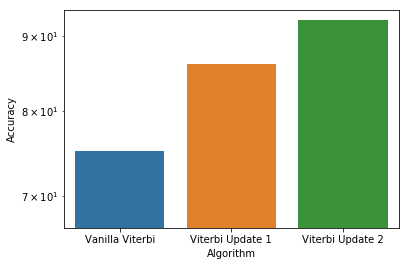

In [22]:
accuracy_array = [float(vanilla_viterbi_accuracy),
                  float(viterbi_update1_accuracy),
                  float(viterbi_update2_accuracy)]
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.yscale('log')
sns.barplot(x=['Vanilla Viterbi','Viterbi Update 1', 'Viterbi Update 2'], y=accuracy_array)

plt.show()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [23]:
def findingCorrectedTags(tagged_seq_vanilla,tagged_seq_updated,words_tag) :
    return [(i,j,k) for i,j,k in zip(tagged_seq_vanilla,tagged_seq_updated,words_tag) if (i != k) & (j == k) ]

In [24]:
# Validation set correction in tags as compared to Vanilla Viterbi vs Viterbi Modification 1 
corrected_by_viterbi_update1 = findingCorrectedTags(vanilla_viterbi_seq,viterbi_update1_seq,validation_word_tag)
pd.DataFrame(corrected_by_viterbi_update1,columns=['Vanilla','VBU1','Actual'])

,Vanilla,VBU1,Actual
0,"(Ruth, DET)","(Ruth, NOUN)","(Ruth, NOUN)"
1,"(Cullowhee, DET)","(Cullowhee, NOUN)","(Cullowhee, NOUN)"
2,"(Card, DET)","(Card, NOUN)","(Card, NOUN)"
3,"(sweepstakes, DET)","(sweepstakes, NOUN)","(sweepstakes, NOUN)"
4,"(R.D., DET)","(R.D., NOUN)","(R.D., NOUN)"
5,"(Vos, DET)","(Vos, NOUN)","(Vos, NOUN)"
6,"(N.Y, DET)","(N.Y, NOUN)","(N.Y, NOUN)"
7,"(Perch, DET)","(Perch, NOUN)","(Perch, NOUN)"
8,"(Dolphin, DET)","(Dolphin, NOUN)","(Dolphin, NOUN)"
9,"(Seahorse, DET)","(Seahorse, NOUN)","(Seahorse, NOUN)"


In [25]:
# Validation set correction in tags as compared to Vanilla Viterbi vs Viterbi Modification 2 
corrected_by_viterbi_update2 = findingCorrectedTags(vanilla_viterbi_seq,viterbi_update2_seq,validation_word_tag)
pd.DataFrame(corrected_by_viterbi_update2,columns=['Vanilla','VBU2','Actual'])

,Vanilla,VBU2,Actual
0,"(Ruth, DET)","(Ruth, NOUN)","(Ruth, NOUN)"
1,"(Cullowhee, DET)","(Cullowhee, NOUN)","(Cullowhee, NOUN)"
2,"(Card, DET)","(Card, NOUN)","(Card, NOUN)"
3,"(R.D., DET)","(R.D., NOUN)","(R.D., NOUN)"
4,"(Vos, DET)","(Vos, NOUN)","(Vos, NOUN)"
5,"(N.Y, DET)","(N.Y, NOUN)","(N.Y, NOUN)"
6,"(Perch, DET)","(Perch, NOUN)","(Perch, NOUN)"
7,"(Dolphin, DET)","(Dolphin, NOUN)","(Dolphin, NOUN)"
8,"(Seahorse, DET)","(Seahorse, NOUN)","(Seahorse, NOUN)"
9,"(Tarwhine, DET)","(Tarwhine, NOUN)","(Tarwhine, NOUN)"


In [26]:
# test sentences correction in tags as compared to Vanilla Viterbi vs Viterbi Modification 1 
corrected_by_viterbi_update1 = findingCorrectedTags(tagged_seq_vanilla,tagged_seq_update1,test_sentences_words_tag)
pd.DataFrame(corrected_by_viterbi_update1,columns=['Vanilla','VBU1','Actual'])

,Vanilla,VBU1,Actual
0,"(Android, DET)","(Android, NOUN)","(Android, NOUN)"
1,"(Android, DET)","(Android, NOUN)","(Android, NOUN)"
2,"(OS, DET)","(OS, NOUN)","(OS, NOUN)"
3,"(worldwide, DET)","(worldwide, NOUN)","(worldwide, NOUN)"
4,"(Google, DET)","(Google, NOUN)","(Google, NOUN)"
5,"(Twitter, DET)","(Twitter, NOUN)","(Twitter, NOUN)"
6,"('s, VERB)","('s, PRT)","('s, PRT)"
7,"(Twitter, DET)","(Twitter, NOUN)","(Twitter, NOUN)"
8,"(interact, DET)","(interact, NOUN)","(interact, NOUN)"
9,"(personality, DET)","(personality, NOUN)","(personality, NOUN)"


In [27]:
# test sentences correction in tags as compared to Vanilla Viterbi vs Viterbi Modification 2 
corrected_by_viterbi_update2 = findingCorrectedTags(tagged_seq_vanilla,tagged_seq_update2,test_sentences_words_tag)
pd.DataFrame(corrected_by_viterbi_update2,columns=['Vanilla','VBU2','Actual'])

,Vanilla,VBU2,Actual
0,"(Android, DET)","(Android, NOUN)","(Android, NOUN)"
1,"(Google, DET)","(Google, NOUN)","(Google, NOUN)"
2,"(Android, DET)","(Android, NOUN)","(Android, NOUN)"
3,"(OS, DET)","(OS, NOUN)","(OS, NOUN)"
4,"(worldwide, DET)","(worldwide, NOUN)","(worldwide, NOUN)"
5,"(2011, DET)","(2011, NUM)","(2011, NUM)"
6,"(2013, DET)","(2013, NUM)","(2013, NUM)"
7,"(Google, DET)","(Google, NOUN)","(Google, NOUN)"
8,"(Twitter, DET)","(Twitter, NOUN)","(Twitter, NOUN)"
9,"(2015, DET)","(2015, NUM)","(2015, NUM)"
